## Load Data

Load the data:
1. clickTrainX contains the predictors for our training data
2. clickTrainY contains the solution for our training data
3. clickTestX contains the predictors for our test data
4. clickTestY contains the solution for our test data

Our dataset contains 13 predictors. `'impressions' 'display_url' 'ad_id' 'advertiser_id' 'depth' 'position' 'query_id' 'keyword_id' 'title_id' 'description_id' 'user_id' 'gender' 'age'`. Using this predictors we are trying to predict the number of clicks.

In [1]:
library (plyr)
library(rpart)
library(caret)
library(corrplot)
library(e1071)
library(hydroGOF)
library(randomForest)
library(elasticnet)
library(nnet)
setwd('/home/davis/seis734/group/ctr-dataprep/sample/')
# we know what the numeric columns in the data
clickTrainX <- read.csv('/home/davis/seis734/group/ctr-dataprep/sample/clickTrainX.csv',sep = ",")
clickTrainY_ <- read.csv('/home/davis/seis734/group/ctr-dataprep/sample/clickTrainY.csv',sep = ",")
clickTestX <- read.csv('clickTestX.csv',sep = ",")
clickTestY_ <- read.csv('clickTestY.csv',sep = ",")
numeric_cols <- names(clickTrainX) %in%  c("impressions","depth","position")

Loading required package: lattice
Loading required package: ggplot2
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: lars
Loaded lars 1.2



By default the `read.csv(...)` function loaded our predictors as numeric. However, some of these predictors are simply IDs that we need to convert to `factors`.

In order to fit the data into our model, the `train` function in the `caret` library expects the `predictors` and the `solution` to be in one dataframe. We will create a new dataframe called `clickTrainData`

In [2]:
# Replace missing values with 0

clickTrainX[is.na(clickTrainX)] <- 0
clickTestX[is.na(clickTestX)] <- 0

# create factors
clickTrainX[!numeric_cols] <- lapply(clickTrainX[!numeric_cols], factor)
clickTestX[!numeric_cols] <- lapply(clickTestX[!numeric_cols], factor)

# convert Y to a vector
clickTrainY <- as.integer(unlist(clickTrainY_, recursive = TRUE, use.names = FALSE))
clickTestY <- as.integer(unlist(clickTestY_, recursive = TRUE, use.names = FALSE))

modelResults <- clickTestY
names(modelResults) <- c("clicks")
# add the solution y to the clickTrainData dataframe
clickTrainData <- clickTrainX
clickTrainData$y <- clickTrainY

# list the columns in the new dataframe
names(clickTrainData)

set.seed(1011)
idx <- createFolds(clickTrainY, returnTrain = TRUE)
ctrl <- trainControl(method = "cv", index = idx)

[1] "impressions"    "display_url"    "ad_id"          "advertiser_id" 
 [5] "depth"          "position"       "query_id"       "keyword_id"    
 [9] "title_id"       "description_id" "user_id"        "gender"        
[13] "age"            "y"

Perform a high level analysis of the data

In [3]:
str(clickTrainX)

'data.frame':	99999 obs. of  13 variables:
 $ impressions   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ display_url   : Factor w/ 6352 levels "1234866103747040",..: 1487 1668 3350 4775 1127 3530 1447 192 3340 1668 ...
 $ ad_id         : Factor w/ 21135 levels "1000515","1000806",..: 6225 19019 19285 2916 13280 17771 4944 14367 18011 19020 ...
 $ advertiser_id : Factor w/ 5452 levels "81","82","87",..: 28 5029 4745 2430 3994 4779 3018 4150 4841 5029 ...
 $ depth         : int  3 2 3 3 1 2 2 2 2 2 ...
 $ position      : int  3 2 3 1 1 1 2 1 2 2 ...
 $ query_id      : Factor w/ 62724 levels "0","1","2","3",..: 1366 32379 39870 1366 39870 40292 53102 7860 40292 38993 ...
 $ keyword_id    : Factor w/ 21597 levels "0","1","2","3",..: 4378 316 13577 2020 14561 17771 1437 10532 17771 3477 ...
 $ title_id      : Factor w/ 29437 levels "0","1","2","3",..: 5226 12635 23575 1153 19828 21985 6679 17540 25581 20798 ...
 $ description_id: Factor w/ 23687 levels "0","1","2","3",..: 567 11763 10184 1370 17426 19

The following variables have too many levels.

1. display_url
2. ad_id
3. advertiser_id
4. query_id
5. keyword_id
6. title_id
7. description_id
8. user_id

We found out that some algorithms fail when some categorical variables have too many values. To solve this problem we decided to remove the variables listed above for some models.

It also appears that `depth` and `position` should be converted to categorical variables

In [4]:
clickTrainX[,5:6] <- lapply(clickTrainX[,5:6], factor)
clickTestX[,5:6] <- lapply(clickTestX[,5:6], factor)

tooManyLevels <- names(clickTrainX) %in%  c("display_url","ad_id","advertiser_id"
                                            ,"query_id","keyword_id","title_id"
                                            ,"description_id","user_id")
clickTrainXAdjusted <- clickTrainX[!tooManyLevels]
clickTestXAdjusted <- clickTestX[!tooManyLevels]
str(clickTrainXAdjusted)

'data.frame':	99999 obs. of  5 variables:
 $ impressions: int  1 1 1 1 1 1 1 1 1 1 ...
 $ depth      : Factor w/ 3 levels "1","2","3": 3 2 3 3 1 2 2 2 2 2 ...
 $ position   : Factor w/ 3 levels "1","2","3": 3 2 3 1 1 1 2 1 2 2 ...
 $ gender     : Factor w/ 3 levels "0","1","2": 2 2 2 2 2 2 2 2 2 2 ...
 $ age        : Factor w/ 7 levels "0","1","2","3",..: 4 4 4 4 4 4 4 4 4 4 ...


Perform one-hot-encoding for the categorical variables

In [5]:
clickTrainXEncoding <- data.frame(clickTrainXAdjusted$impressions)
clickTrainXEncoding <- cbind(clickTrainXEncoding, data.frame(model.matrix(~clickTrainXAdjusted$depth-1)))
clickTrainXEncoding <- cbind(clickTrainXEncoding, data.frame(model.matrix(~clickTrainXAdjusted$position-1)))
clickTrainXEncoding <- cbind(clickTrainXEncoding, data.frame(model.matrix(~clickTrainXAdjusted$gender-1)))
clickTrainXEncoding <- cbind(clickTrainXEncoding, data.frame(model.matrix(~clickTrainXAdjusted$age-1)))

#Test 
clickTestXEncoding <- data.frame(clickTrainXAdjusted$impressions)
clickTestXEncoding <- cbind(clickTestXEncoding, data.frame(model.matrix(~clickTrainXAdjusted$depth-1)))
clickTestXEncoding <- cbind(clickTestXEncoding, data.frame(model.matrix(~clickTrainXAdjusted$position-1)))
clickTestXEncoding <- cbind(clickTestXEncoding, data.frame(model.matrix(~clickTrainXAdjusted$gender-1)))
clickTestXEncoding <- cbind(clickTestXEncoding, data.frame(model.matrix(~clickTrainXAdjusted$age-1)))

# Rename columns
col_names <- c("impressions"
              ,"depth1"
              ,"depth2"
              ,"depth3"
              ,"position1"
              ,"position2"
              ,"position3"
              ,"gender0"
              ,"gender1"
              ,"gender2"
              ,"age0"
              ,"age1"
              ,"age2"
              ,"age3"
              ,"age4"
              ,"age5"
              ,"age6")

names(clickTrainXEncoding) <- col_names
names(clickTestXEncoding) <- col_names
str(clickTrainXEncoding)

'data.frame':	99999 obs. of  17 variables:
 $ impressions: int  1 1 1 1 1 1 1 1 1 1 ...
 $ depth1     : num  0 0 0 0 1 0 0 0 0 0 ...
 $ depth2     : num  0 1 0 0 0 1 1 1 1 1 ...
 $ depth3     : num  1 0 1 1 0 0 0 0 0 0 ...
 $ position1  : num  0 0 0 1 1 1 0 1 0 0 ...
 $ position2  : num  0 1 0 0 0 0 1 0 1 1 ...
 $ position3  : num  1 0 1 0 0 0 0 0 0 0 ...
 $ gender0    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ gender1    : num  1 1 1 1 1 1 1 1 1 1 ...
 $ gender2    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ age0       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ age1       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ age2       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ age3       : num  1 1 1 1 1 1 1 1 1 1 ...
 $ age4       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ age5       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ age6       : num  0 0 0 0 0 0 0 0 0 0 ...


## Basic Regression Tree

Our first model is a single Regression tree. Becauase of the simplicity of this model we expect the model to have sub-optimal predictive performance. Additionally with this type of tree we have a finite number of possible predicted outcomes which is determined by the number of terminal nodes. As a result we are not able to capture observations outside the training data set.

To test the quality of the model we use `RMSE`. We expect this tree to have the highest `RMSE` value because of it's simplicity.

In this model we use the `rpart` method of the caret library with a `tuneLegth = 30` using cross-validation. Our plot should contain 30 points that show how the `RMSE` changes with a change in the complexity parameter. The complexity parameter penalizes the error rate using the size of the tree. The goal is to find the the smallest tree with the lowest penalized rate.

$$SSE_{c_{p}} = SSE + c_{p} ∗ (Num Terminal Nodes)$$

In [72]:
start.time <- Sys.time()

# Tune the model
set.seed(1011)
cartTune <- train(x = clickTrainXEncoding, y = clickTrainY,
                  method = "rpart",
                  tuneLength = 30,
                  trControl = ctrl)

time.taken <- Sys.time() - start.time

cat("Duration ", time.taken, " seconds")
cartTune

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

Duration  23.35978  seconds

CART 

99999 samples
   17 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 89999, 89999, 89999, 89999, 89999, 89999, ... 
Resampling results across tuning parameters:

  cp            RMSE       Rsquared  
  0.0001879300  0.2863961  0.15641464
  0.0002232318  0.2863959  0.15632967
  0.0002267204  0.2863837  0.15638502
  0.0002288656  0.2863821  0.15639116
  0.0002297421  0.2863821  0.15639116
  0.0002576505  0.2863976  0.15624805
  0.0002636898  0.2861763  0.15717834
  0.0002679865  0.2861735  0.15708589
  0.0002779490  0.2861539  0.15719278
  0.0003140244  0.2860959  0.15728904
  0.0003215824  0.2860543  0.15739215
  0.0003273014  0.2859715  0.15778499
  0.0004363129  0.2857644  0.15908273
  0.0005788966  0.2854956  0.16065802
  0.0006094530  0.2854833  0.16073558
  0.0007835899  0.2852592  0.16197453
  0.0008628999  0.2851955  0.16213778
  0.0009027613  0.2853063  0.16156790
  0.0009085728  0.2853231  0.16151261
  0.0010094374  0.2850365 

Now that we have our model we can plot to see the `RMSE`

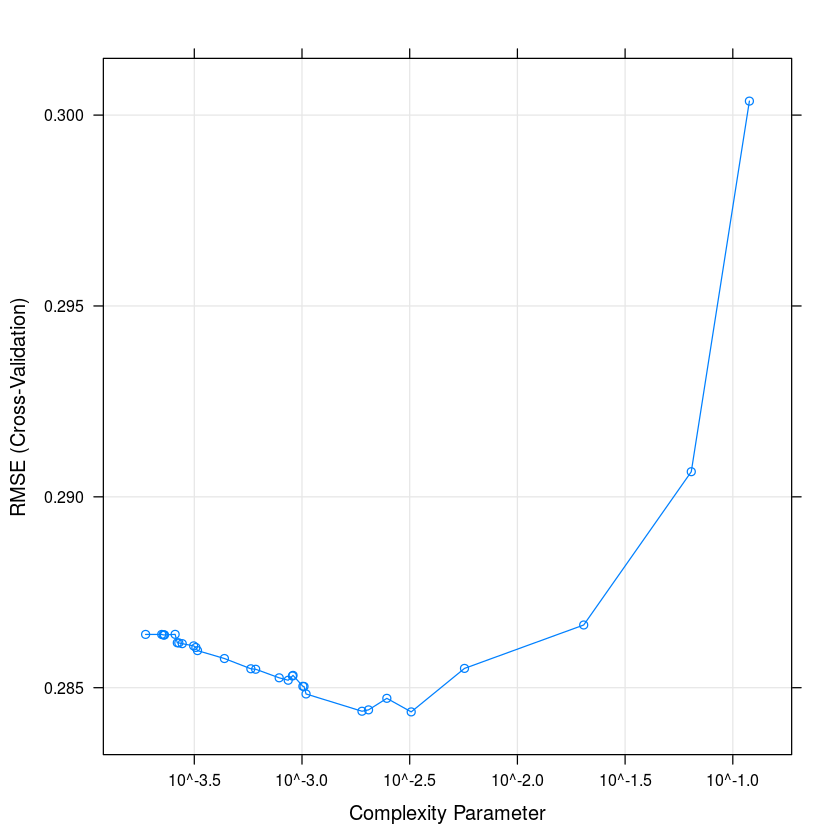

In [73]:
plot(cartTune, scales = list(x = list(log = 10)))

Next we check which variables the model thought were most important

In [74]:
cartImp <- varImp(cartTune, scale = FALSE, competes = FALSE)
cartImp

rpart variable importance

            Overall
impressions 0.49202
depth1      0.04701
position1   0.02265
gender2     0.00000
age1        0.00000
position3   0.00000
depth2      0.00000
age3        0.00000
age2        0.00000
gender1     0.00000
age4        0.00000
position2   0.00000
gender0     0.00000
age0        0.00000
age6        0.00000
depth3      0.00000
age5        0.00000

The results indicate that the `impressions` `depth` and `position` are the best predictors for the number of clicks. This seems correct from our understanding of the data. It makes sense that `impresions` is the best predictors because the more impressions an Ad has the more chances it has to get clicks. `depth` and `position` relate to the positioning of an Ad on a webpae. Ads at the top of the page are more likely to be clicked than those at the bottom of the page. The models indicate that Ads at position 1 and depth 1 are more likely to generate clicks

impressions   depth1      depth2      
impressions  1.0000000000  0.00438875 -0.002910438
depth1       0.0043887501  1.00000000 -0.506376832
depth2      -0.0029104380 -0.50637683  1.000000000
depth3      -0.0009769657 -0.39002359 -0.596522454
position1    0.0016054730  0.52330716 -0.124976620
position2   -0.0015141857 -0.40750939  0.353301572

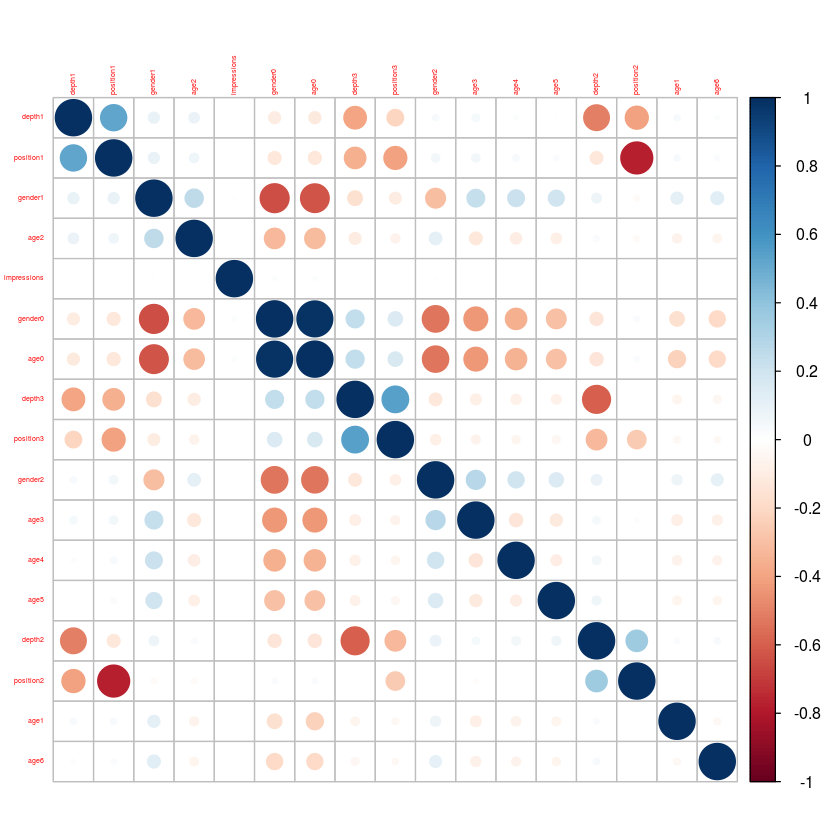

In [75]:
clickCorr <- cor(clickTrainXEncoding)
corrplot(clickCorr, order = "hclust", tl.cex = .35)
head(clickCorr[,1:3])

We can simplify the model by removing predictors witha high correlation.

In [10]:
highCorr <- findCorrelation(clickCorr, cutoff = 0.75)
head(highCorr)
filteredClickTrainXEncoding <- clickTrainXEncoding[,-highCorr]
filteredClickTestXEncoding <- clickTestXEncoding[,-highCorr]
str(filteredClickTrainXEncoding)
str(filteredClickTestXEncoding)

cat('The following predictors will be removed\n',names(clickTestXEncoding)[highCorr])

ERROR: Error in is.data.frame(x): object 'clickCorr' not found


Eventhough we don't have high correlations in the data, some models are very sensitive to skewness. We check for skewness using the `skewness` function in the `e1071` library.

impressions      depth1      depth2      depth3   position2   position3 
272.6358139   1.1625088   0.2562567   0.7974486   0.7037577   2.3583524 
    gender0     gender1     gender2        age1        age2        age3 
 -0.1400414   1.0771851   1.4831115   4.5127434   3.0148906   2.0265388 
       age4        age5        age6 
  2.7094837   3.3269182   5.1602744

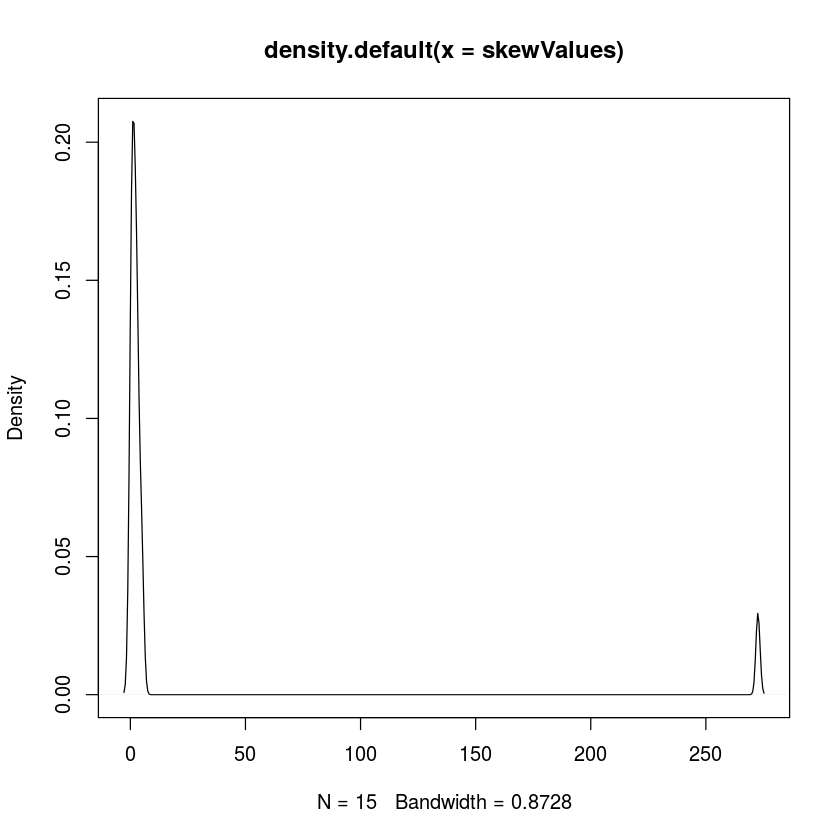

In [79]:
skewValues <- apply(filteredClickTrainXEncoding,2, skewness)
plot(density(skewValues))
skewValues

It can be observed that our data has extreme skewness. We will use the `BoxCoxTrans` function of the `caret` package to find the appropriate tranasformations for our data.

The new model will use the same algorithm but fewer variables and transformed data

Generate new model using the transformed data

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

Duration  37.36929  seconds

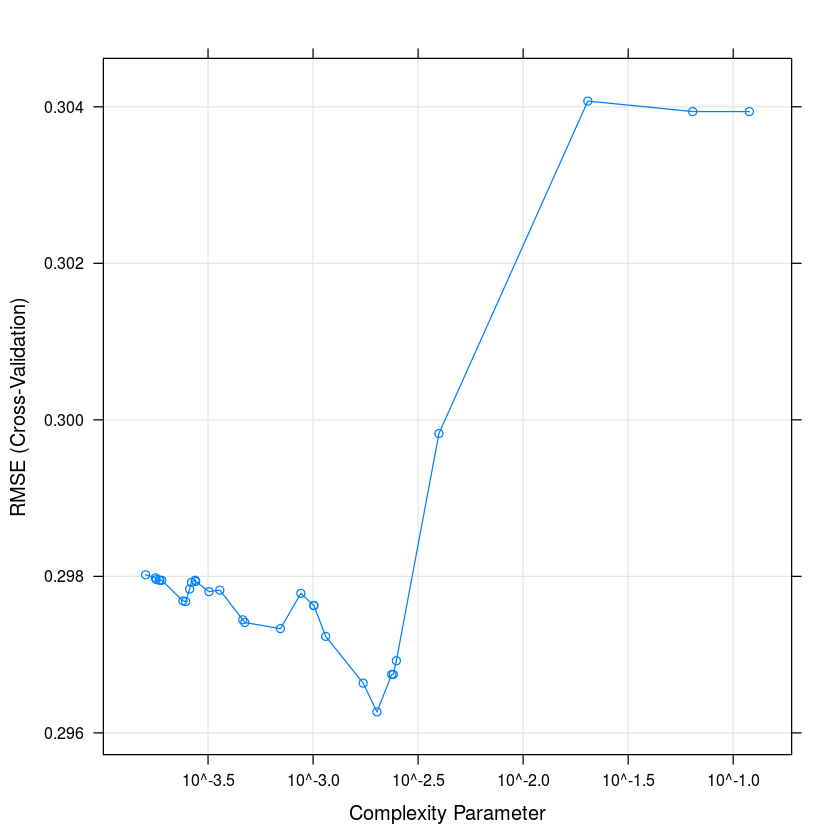

In [93]:
start.time <- Sys.time()
# Box Cox Transformation
set.seed(1011)
cartTuneTrans <- train(x = filteredClickTrainXEncoding, y = clickTrainY,
                       method = "rpart",
                       tuneLength = 30,
                       trControl = ctrl,
                       preProc = c("pca","BoxCox"))

time.taken <- Sys.time() - start.time
cat("Duration ", time.taken, " seconds")

plot(cartTuneTrans, scales = list(x = list(log = 10)))

Now we can use the two models to generate predictions on our test data.

In [94]:
cartTuneResults <- data.frame(obs = clickTestY,
                          CART = predict(cartTune, clickTestXEncoding))
cartTuneTransResults <- data.frame(obs = clickTestY,
                          CART = predict(cartTuneTrans, filteredClickTestXEncoding))

cat("cartTune RMSE", rmse(cartTuneResults$obs, cartTuneResults$CART),"\n")
cat("cartTuneTrans RMSE", rmse(cartTuneTransResults$obs, cartTuneTransResults$CART),"\n")

cartTune RMSE 0.6084502 
cartTuneTrans RMSE 0.6024712 


From the above results it appears that the BoxCox transformation along with `PCA` slightly increase the prediction quality of the model.

Next we save the predictions to the modelResults dataframe

In [99]:
modelResults$CART <- data.frame(CART=predict(cartTune, clickTestXEncoding))
modelResults$CART_TRANS <- data.frame(CART_TRANS=predict(cartTuneTrans, filteredClickTestXEncoding))

## Ramdom Forests

Bagging is a technique that uses bootstrapping in conjunction with any regression model to construct an ensemble. Bagging reduces the variance of the predictions through the aggregation process.

Random Forests add randomness into the learning process. The randomness reduces the correlation between trees.

In [100]:
rfGrid <- data.frame(mtry = floor(seq(10, ncol(filteredClickTrainXEncoding), length = 10)))
rfData <- filteredClickTrainXEncoding
rfData$y <- clickTrainY

start.time <- Sys.time()
set.seed(1011)
randomForest <- train(y ~. 
                      , data = rfData
                      ,method = "rf"
                      ,tuneGrid = rfGrid
                      ,ntree = 13
                      ,importance = TRUE
                      ,trControl = ctrl)

time.taken <- Sys.time() - start.time
randomForest
cat("Duration ", time.taken, " seconds")

Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
“invalid mtry: reset to within valid range”Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
“invalid mtry: reset to within valid range”Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
“invalid mtry: reset to within valid range”Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
“invalid mtry: reset to within valid range”Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
“invalid mtry: reset to within valid range”Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
“invalid mtry: reset to within valid range”Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
“invalid mtry: reset to within valid range”Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
“invalid mtry: reset to within valid range”Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
“invalid mtry: re

Random Forest 

99999 samples
   15 predictors

Pre-processing: principal component signal extraction (15),
 Box-Cox transformation (1), centered (15), scaled (15) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 89999, 89999, 89999, 89999, 89999, 89999, ... 
Resampling results across tuning parameters:

  mtry  RMSE       Rsquared 
  10    0.3056528  0.1268948
  11    0.3046542  0.1277777
  12    0.3036993  0.1305194
  13    0.3039100  0.1393790
  14    0.3040220  0.1205955
  15    0.3059533  0.1313502

RMSE was used to select the optimal model using  the smallest value.
The final value used for the model was mtry = 12. 

Duration  29.15574  seconds

Check Variable Importance for the model

rf variable importance

     Overall
PC10   4.748
PC11   4.587
PC1    3.995
PC2    3.681
PC8    3.086
PC5    3.005
PC4    2.959
PC6    2.205
PC7    1.972
PC9    1.625
PC3    1.245

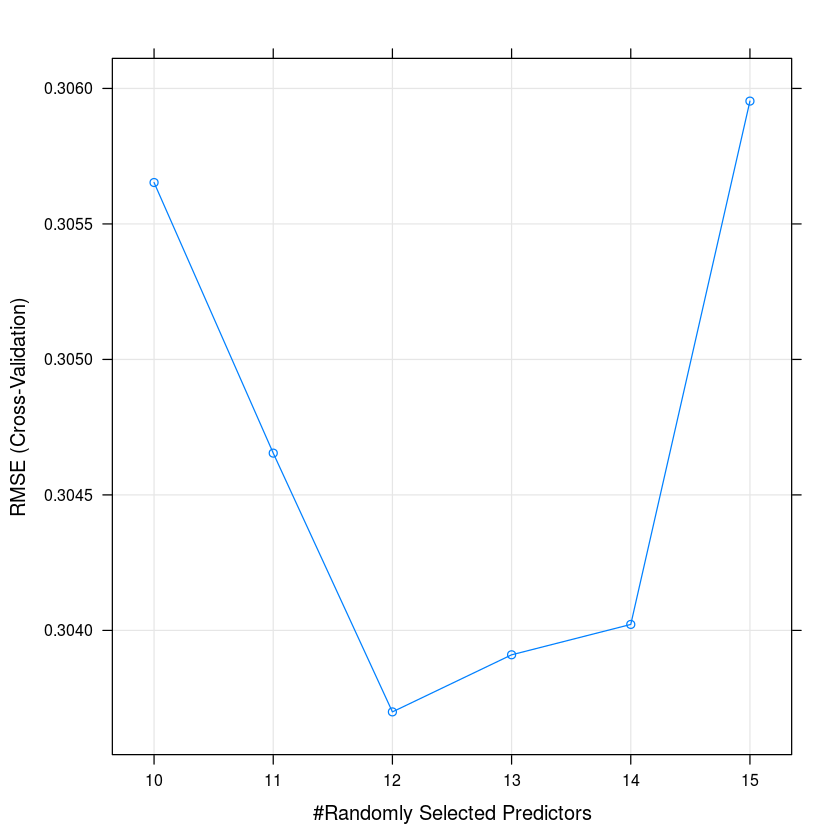

In [102]:
plot(randomForest)
randomForestImp <- varImp(randomForest, scale = FALSE)
randomForestImp

In [104]:
randomForestResults <- data.frame(obs = clickTestY,
                          CART = predict(randomForest, filteredClickTestXEncoding))
modelResults$RANDOM_FOREST <- data.frame(RANDOM_FOREST=predict(randomForest, filteredClickTestXEncoding))
cat("randomForestResults RMSE", rmse(randomForestResults$obs, randomForestResults$CART),"\n")


randomForestResults RMSE 0.6169271 


## Lasso

Lasso performas variable selection and regulalization to enhance prediction accuracy. We used the `enet` function of the `elasticnet` package to generate this model.

Elasticnet 

99999 samples
   15 predictors

Pre-processing: principal component signal extraction (15),
 Box-Cox transformation (1), centered (15), scaled (15) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 89999, 89999, 89999, 89999, 89999, 89999, ... 
Resampling results across tuning parameters:

  lambda  fraction    RMSE       Rsquared   
  0.00    0.05000000  0.3036689  0.007879302
  0.00    0.08275862  0.3035120  0.007879302
  0.00    0.11551724  0.3033707  0.007879302
  0.00    0.14827586  0.3032452  0.007879302
  0.00    0.18103448  0.3031354  0.007879302
  0.00    0.21379310  0.3030426  0.007902014
  0.00    0.24655172  0.3029617  0.008293426
  0.00    0.27931034  0.3028831  0.008704912
  0.00    0.31206897  0.3028124  0.009017593
  0.00    0.34482759  0.3027496  0.009253881
  0.00    0.37758621  0.3026958  0.009450092
  0.00    0.41034483  0.3026482  0.009655361
  0.00    0.44310345  0.3026052  0.009847000
  0.00    0.47586207  0.3025678  0.010003008
  0.00

            Length Class      Mode     
call          4    -none-     call     
actions      12    -none-     list     
allset       11    -none-     numeric  
beta.pure   132    -none-     numeric  
vn           11    -none-     character
mu            1    -none-     numeric  
normx        11    -none-     numeric  
meanx        11    -none-     numeric  
lambda        1    -none-     numeric  
L1norm       12    -none-     numeric  
penalty      12    -none-     numeric  
df           12    -none-     numeric  
Cp           12    -none-     numeric  
sigma2        1    -none-     numeric  
xNames       11    -none-     character
problemType   1    -none-     character
tuneValue     2    data.frame list     
obsLevels     1    -none-     logical  

LASSO RMSE 0.5916023 
Duration  1.188859  seconds

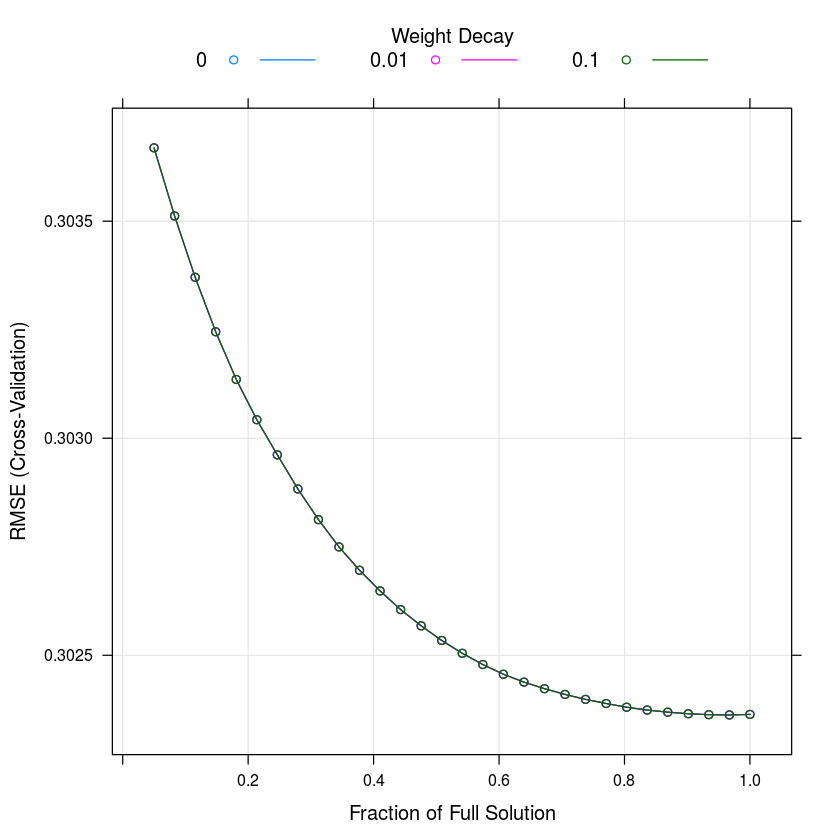

In [97]:
enetGrid <- expand.grid(lambda = c(0, 0.01, .1), 
                        fraction = seq(.05, 1, length = 30))

start.time <- Sys.time()
set.seed(1011)
lassoTune <- train(x = as.matrix(filteredClickTrainXEncoding), y = clickTrainY,
                  method = "enet",
                  tuneGrid = enetGrid,
                  trControl = ctrl,
                  preProc = c("pca","BoxCox"))

time.taken <- Sys.time() - start.time

lassoTune
summary(lassoTune)
plot(lassoTune)

lassoTuneResults <- data.frame(obs = clickTestY,
                          LASSO = predict(lassoTune, filteredClickTestXEncoding))

cat("LASSO RMSE", rmse(lassoTuneResults$obs, lassoTuneResults$LASSO),"\n")
modelResults$lasso <- predict(lassoTune, filteredClickTestXEncoding)
cat("Duration ", time.taken, " seconds")

LASSO had an `RMSE` 0.5916023 which is better than the best RMSE of the Single Regression Trees model

## Neural Networks

Neural Networks are non-linear regression models inspired by how the brain works. They are modeled by an intermediary set of unobserved varialbles called hidden units. Each unit is a combination of some or all of the predictor variables.

The `nnet` function in the `nnet` package can be used to build a neural network.

We used the `nnet` function to create a neural network of 20 hidden units

In [ ]:
# start.time <- Sys.time()
# set.seed(1011)
# nnetGrid <- expand.grid(decay = c(0, 0.01, .1), 
#                         size = c(1, 3, 5, 7, 9, 11, 13), 
#                         bag = FALSE)

# set.seed(1011)
# neuralNet <- train(x = filteredClickTrainXEncoding, y = clickTrainY,
#                   method = "avNNet",
#                   tuneGrid = nnetGrid,
#                   trControl = ctrl,
#                   linout = TRUE,
#                   trace = FALSE,
#                   MaxNWts = 13 * (ncol(filteredClickTrainXEncoding) + 1) + 13 + 1,
#                   maxit = 1000,
#                   allowParallel = FALSE)
# time.taken <- Sys.time() - start.time
# neuralNet

# plot(neuralNet)

# neuralNetResults <- data.frame(obs = clickTestY,
#                           NEUREL_NET = predict(neuralNet, filteredClickTestXEncoding))

# cat("NEAURAL NET RMSE", rmse(neuralNetResults$obs, neuralNetResults$NEUREL_NET),"\n")
# modelResults$NEUREL_NET <- predict(neuralNet, filteredClickTestXEncoding)
# cat("Duration ", time.taken, " seconds")

Make predictions using the neural network

## Summary


In [ ]:
modelResamples <- resamples(list(
                     "Single Tree" = cartTune,
                     "Single Tree Trans" = cartTuneTrans,
                     "Random Forest" = randomForest,
                     "LASSO" = lassoTune 
#,
#                      "Neural Network" = neuralNet
))

Visualise the RMSE values

In [ ]:
# RMSE Plot
library(caret)
parallelplot(modelResamples)

In [ ]:
parallelplot(modelResamples, metric = "Rsquared")